In [1]:
# Cell 1 — imports & regex
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # remove decompression-limit check


_SAMPLE_ID_RE = re.compile(r"^(?:processed_)?25[_-]0*([0-9]+R?)")

def _parse_sample_id(fname):
    """Extracts the integer sample ID from filenames like '25-001_foo.tif'."""
    m = _SAMPLE_ID_RE.search(os.path.basename(fname))
    if not m:
        raise ValueError(f"Can't parse sample ID from {fname!r}")
    return m.group(1)


In [2]:
# Cell 2 — discover filepaths
def _collect_mask_paths(input_folder):
    """Returns a dict sample_id → dict of the three mask paths."""
    base = Path(input_folder)
    masks = {"cell": base/"cell_masks", "nucleus": base/"nuclei_masks", "mito": base/"Mitos_thresh",
             "glycogen": base/"glycogen_thresh", "ER": base/"ER_thresh"}
    samples = {}
    for kind, folder in masks.items():
        suffix = ".tif"
        if kind == "glycogen":
            suffix = ".png"
        for fp in folder.glob(f"*{suffix}"):
            if "25_0581-5nm-R1.tif" in fp.name:
                continue
            sid = _parse_sample_id(fp.name)
            samples.setdefault(sid, {})[kind] = fp
    # sanity check
    #for sid, d in samples.items():
    #    if set(d) != {"cell","nucleus","mito", "ld"}:
    #        raise RuntimeError(f"Missing mask(s) for sample {sid}: {d}")
    return samples

In [22]:
from skimage.measure import regionprops
import numpy as np
import pandas as pd

def _summarize_cells_for_sample(cell_mask, nucleus_mask, mito_mask, glycogen_mask, er_mask, sample_id):
    """
    Fast per-cell summarization using bincount and regionprops.
    Returns a DataFrame with columns:
      sample_id, cell_label, cell_area, nucleus_count,
      nucleus_area, nucleus_frac, mito_frac, cyto_frac,
      cell_au_frac, nuc_au_frac, mito_au_frac, cyto_au_frac,
      au_nuc_pct, au_mito_pct, au_cyto_pct
    """
    # Flatten all our masks once
    flat_cell       = cell_mask.ravel()

    flat_nucleus    = (nucleus_mask.ravel() > 0)
    flat_mito_excl  = (mito_mask.ravel() > 0) & ~flat_nucleus
    flat_glycogen   = flat_cell == 3
    flat_er         = (er_mask.ravel() > 0) & ~flat_mito_excl & ~flat_nucleus & ~flat_glycogen

    max_label = int(flat_cell.max())

    # 1) Pixel counts per label
    area      = np.bincount(flat_cell,                      minlength=max_label+1)
    nuc_area  = np.bincount(flat_cell[flat_nucleus],        minlength=max_label+1)
    mito_area = np.bincount(flat_cell[flat_mito_excl],      minlength=max_label+1)
    glycogen_area = np.bincount(flat_cell[flat_glycogen],            minlength=max_label+1)
    er_area   = np.bincount(flat_cell[flat_er],            minlength=max_label+1)
    cyto_area = area - nuc_area - mito_area - glycogen_area - er_area

    # 3) Count how many distinct nuclei land in each cell
    nuc_count = np.zeros(max_label+1, dtype=int)
    for prop in regionprops(nucleus_mask):
        y, x = map(int, prop.centroid)
        lab = int(cell_mask[y, x])
        if lab > 0:
            nuc_count[lab] += 1

    # 4) Assemble results for each real cell label
    records = []
    cell_labels = np.nonzero(area[1:])[0] + 1  # skip background=0
    for lab in cell_labels:
        A = area[lab]
        nA, mA, cA, gA, eA = nuc_area[lab], mito_area[lab], cyto_area[lab], glycogen_area[lab], er_area[lab]

        records.append({
            "sample_id":     sample_id,
            "cell_label":    lab,
            "cell_area":     A,
            "nucleus_count": nuc_count[lab],
            "nucleus_area":  nA,
            "nucleus_frac":  nA / A,
            "mito_frac":     mA / A,
            "glycogen_frac": gA / A,
            "er_frac":       eA / A,
            "cyto_frac":     cA / A,
        })

    return pd.DataFrame.from_records(records)


In [ ]:
import numpy as np
import tifffile
from pathlib import Path
import pandas as pd
from PIL import Image

# ─── Helper: pad or crop to target_shape ────────────────────────────────────────
def _resize_to(img: np.ndarray, target_shape: tuple[int,int]) -> np.ndarray:
    """
    Pads with zeros or crops on bottom/right so that
    `img.shape == target_shape`.
    """
    h_tgt, w_tgt = target_shape
    h, w = img.shape
    if img.shape == target_shape:
        return img

    # crop if too big
    h_crop = min(h, h_tgt)
    w_crop = min(w, w_tgt)
    img = img[:h_crop, :w_crop]

    # pad if too small
    pad_h = h_tgt - h_crop
    pad_w = w_tgt - w_crop
    if pad_h > 0 or pad_w > 0:
        img = np.pad(
            img,
            ((0, pad_h), (0, pad_w)),
            mode="constant",
            constant_values=0
        )
    return img

# ─── (Re-)define load_all_cells with resizing ──────────────────────────────────
def load_all_cells(input_folder: str, output_file: str) -> pd.DataFrame:
    """
    Scans the input_folder and returns a DataFrame
    with one row per cell, with all the metrics described.
    Automatically pads/crops the cell & nucleus masks
    to match your mito_mask (and Au image) shape.
    """
    samples = _collect_mask_paths(input_folder)
    if not Path(output_file).exists():
        with open(output_file, "w") as f:
            print("created the file")
    i=0
    for sid, paths in samples.items():
        i+=1
        if sid != "585":
            continue
        # 1) load masks
        cell_mask_raw    = tifffile.imread(paths["cell"])
        nucleus_mask_raw = tifffile.imread(paths["nucleus"])
        mito_mask        = tifffile.imread(paths["mito"]) > 0
        glycogen_mask    = np.array(Image.open(paths["glycogen"])) > 0
        er_mask          = tifffile.imread(paths["ER"]) > 0

        # 2) ensure shapes match by resizing cell & nucleus masks to mito_mask.shape
        
        target_shape = mito_mask.shape
        
        cell_mask    = _resize_to(cell_mask_raw,    target_shape)
        nucleus_mask = _resize_to(nucleus_mask_raw, target_shape)

        # 4) summarize this sample
        df = _summarize_cells_for_sample(
            cell_mask=cell_mask,
            nucleus_mask=nucleus_mask,
            mito_mask=mito_mask.astype(np.uint8),
            glycogen_mask=glycogen_mask.astype(np.uint8),
            er_mask=er_mask.astype(np.uint8),
            sample_id=sid
        )
        df.to_csv(output_file, mode="a", header=i==1)
        #all_dfs.append(df)

    # 5) concatenate and return
    return None


In [24]:
df = load_all_cells("/Users/chris/Documents/lab/experiments/2025-0610-diazoxide", "./dzx-cells.csv")
#df.to_csv("./dzx-cells.csv")

#{'853': {
# 'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25-853_Region 6_07052025.tif'), 
# 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25-853_Region 6_07052025.tif'), 
# 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25-853_Region 6_07052025.tif')}, 
# 
# '586': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25_0586-5nm-R4.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25_0586-5nm-R4.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25_0586-5nm-R4.tif')}, '851R': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25-851R_Region 6_07052025.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25-851R_Region 6_07052025.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25-851R_Region 6_07052025.tif')}, '857': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25-857_Region 6_07052025.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25-857_Region 6_07052025.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25-857_Region 6_07052025.tif')}, '858': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25-858_Region 6_07052025.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25-858_Region 6_07052025.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25-858_Region 6_07052025.tif')}, '582': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25_0582-5nm-R2.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25_0582-5nm-R2.tif')}, '854': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25-854_Region 6_07052025.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25-854_Region 6_07052025.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25-854_Region 6_07052025.tif')}, '585': {'cell': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/cell_masks/25_0585-5nm-R3.tif'), 'mito': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos_thresh/processed_25_0585-5nm-R3.tif'), 'ER': PosixPath('/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/ER_thresh/processed_25_0585-5nm-R3.tif')}}
853


cell_mask_raw.shape (44070, 62827)
nucleus_mask_raw.shape (43767, 62144)
mito_mask.shape (44912, 63119)
glycogen_mask.shape (44258, 63271)
er_mask.shape (44912, 63119)


853

In [27]:
df = pd.read_csv("/Users/chris/Documents/lab/emAnalysis/backend/server/dzx-cells.csv")
print(df["sample_id"].unique())

['853' '586' '851R' '857' '858' '582' '854' '585']


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_violins(df, column, plot_type='cell', nucleus_required=False):
    """
    Creates side-by-side violin plots for three experimental groups:
      - '6hr fast': samples 73, 75, 77
      - '1hr glucose': samples 79, 81, 83
      - 'ON fast': samples 85, 87, 89

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain 'sample_id' and the specified column.
    column : str
        Name of the numeric column to plot.
    plot_type : {'cell', 'animal'}
        - 'cell': use individual cell values, color-coded by sample.
        - 'animal': average per sample_id; violin has 3 values per group.
    """
    df = df[df['sample_id'] != "585"]
    df = df[df["nucleus_count"] > 0]
    if nucleus_required:
        df = df[df.get('nucleus_count', 0) > 0]
    # define which sample IDs belong to each group
    group_map = {
        'CTRl': ["851R", "582", "853", "854"],
        'DZX': ["585", "586", "857", "858"],
    }
    groups = list(group_map.keys())
    data = []

    if plot_type == 'cell':
        # collect the raw cell-level values for each group
        for grp in groups:
            ids = group_map[grp]
            vals = df.loc[df['sample_id'].isin(ids), column].values
            print(grp, vals.shape)
            data.append(vals)
        

        fig, ax = plt.subplots()
        ax.violinplot(data,
                      positions=range(len(groups)),
                      showmeans=False,
                      showmedians=True)
        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels(groups)
        ax.set_ylabel(column)

        # assign each sample its own color
        unique_ids = sorted(df['sample_id'].unique())
        cmap = plt.get_cmap('tab10', len(unique_ids))
        id_to_color = {sid: cmap(i) for i, sid in enumerate(unique_ids)}

        # overlay individual points with jitter
        for i, grp in enumerate(groups):
            ids = group_map[grp]
            sub = df[df['sample_id'].isin(ids)]
            jitter = 0.08
            x = np.random.rand(len(sub)) * jitter + i
            y = sub[column]
            colors = [id_to_color[sid] for sid in sub['sample_id']]
            ax.scatter(x, y, c=colors, s=10)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'animal':
        # average per sample_id first, then build the group lists
        avg = df.groupby('sample_id')[column].mean().dropna().reset_index()
        for grp in groups:
            ids = group_map[grp]
            vals = avg.loc[avg['sample_id'].isin(ids), column].values
            print(grp, vals)
            data.append(vals)

        fig, ax = plt.subplots()
        ax.violinplot(data,
                      positions=range(len(groups)),
                      showmeans=False,
                      showmedians=True)
        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels(groups)
        ax.set_ylabel(column)
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("plot_type must be 'cell' or 'animal'")

# Example usage:
# plot_group_violins(df, 'cell_area', 'cell')
# plot_group_violins(df, 'cell_area', 'animal')


CTRl (247,)
DZX (218,)


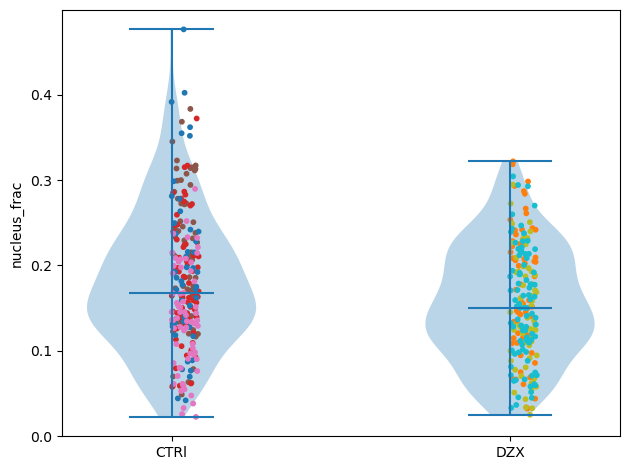

CTRl (247,)
DZX (218,)


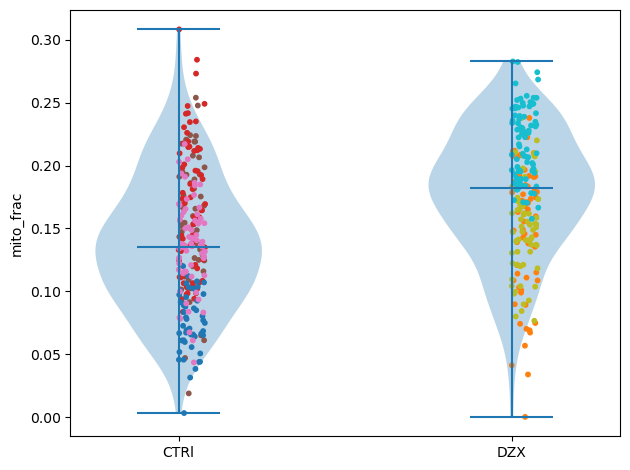

CTRl (247,)
DZX (218,)


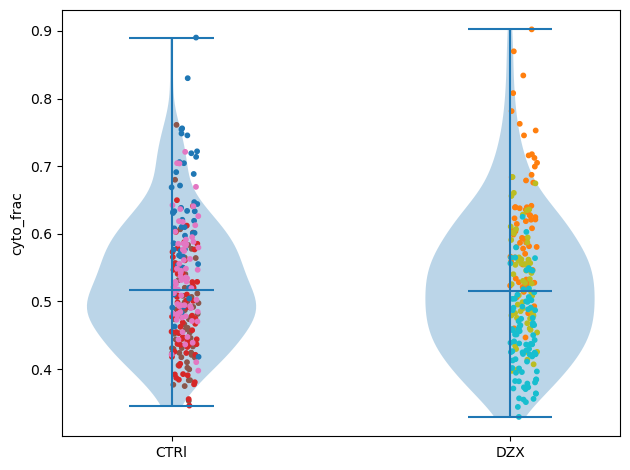

CTRl (247,)
DZX (218,)


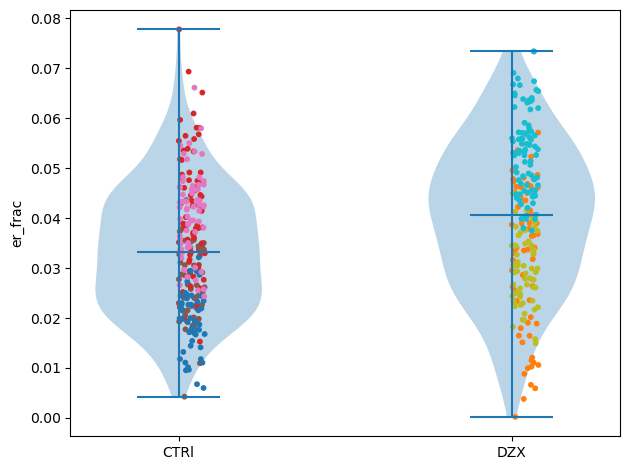

CTRl (247,)
DZX (218,)


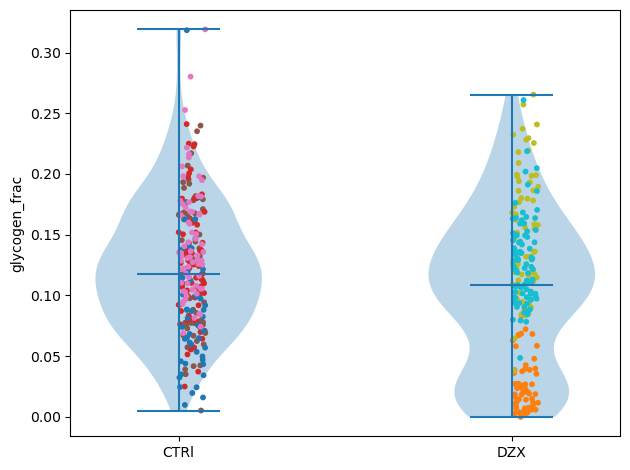

In [39]:
import pandas as pd


"""{
            "sample_id": sample_id,
            "cell_label": lab,
            "cell_area": cell_area,
            "nucleus_count": nucleus_count,
            "nucleus_area": nucleus_area,
            "nucleus_frac": nuc_frac,
            "mito_frac": mito_frac,
            "cyto_frac": cyto_frac,
            "cell_au_frac": cell_au_frac,
            "nuc_au_frac": nuc_au_frac,
            "mito_au_frac": mito_au_frac,
            "cyto_au_frac": cyto_au_frac,
            "au_nuc_pct": au_nuc_pct,
            "au_mito_pct": au_mito_pct,
            "au_cyto_pct": au_cyto_pct,
        })"""
plot_group_violins(df, 'nucleus_frac', 'cell', nucleus_required=False)
plot_group_violins(df, 'mito_frac', 'cell', nucleus_required=False)
plot_group_violins(df, 'cyto_frac', 'cell', nucleus_required=False)
plot_group_violins(df, 'er_frac', 'cell', nucleus_required=False)
plot_group_violins(df, 'glycogen_frac', 'cell', nucleus_required=False)

